In [25]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

Problem 2

1. Extract historical data on the stocks of your interest INTC, and SSAB-A.ST

In [64]:
def extract_data(ticker_symbol, start_date,end_date):
    """
    Fetch ticker data from Yahoo Finance
    """
    ticker=yf.Ticker(ticker_symbol)
    ticker_data=ticker.history(start=start_date,end=end_date)
    ticker_data.index = ticker_data.index.tz_localize(None)
    return ticker_data

In [65]:
# Extract INTC data
intc_data = extract_data("INTC", "2011-01-01", "2025-06-30").loc[:, ['Close']]
intc_data.head()

#Filter data from 2021 onwards (observed data)
observed_intc=intc_data[intc_data.index >= '2021-01-01']

#Filter data from 2021 backwards (historical data)
historical_intc = intc_data[intc_data.index < '2021-01-01']


In [28]:
# Extract SSAB data in SEK and convert to USD
ssab_data = extract_data("SSAB-A.ST", "2011-01-01", "2025-06-30").loc[:, ['Close']]
sek2usd = extract_data("SEKUSD=X", "2011-01-01", "2025-06-30").loc[:, ['Close']]
ssab_data=pd.merge(left=ssab_data, right=sek2usd, left_index=True, right_index=True, how='left', suffixes=('_inSEK', '_sek2usd'))
ssab_data['Close_sek2usd'].fillna(method='ffill', inplace=True)

ssab_data['Close'] = ssab_data['Close_inSEK'] * ssab_data['Close_sek2usd']
#Filter data from 2021 onwards (observed data)
observed_ssab = ssab_data[ssab_data.index >= '2021-01-01']

#Filter data from 2021 backwards (historical data)
historical_ssab = ssab_data[ssab_data.index < '2021-01-01']


In [29]:
INVESTMENT_AMOUNT_EACH = 500  #USD
#Initial price and shares of each stock
initial_price_intc = observed_intc['Close'].iloc[0]
initial_price_ssab = observed_ssab['Close'].iloc[0]
intc_shares=INVESTMENT_AMOUNT_EACH/initial_price_intc
ssab_shares=INVESTMENT_AMOUNT_EACH/initial_price_ssab

2. Derive mean daily log-return of the share prices based on their daily closing price. Note that if $X_t$ is the closing share price at day “t” then log-return is defined as $R_t = \log\left(\frac{X_t}{X_{t-1}}\right)$

In [30]:
def compute_log_return(hist_data):
    '''
    Compute log returns from historical price data
    '''
    log_returns = pd.DataFrame()
    log_returns['daily_log_return'] = np.log(hist_data['Close'] / hist_data['Close'].shift(1))
    log_returns.dropna(inplace=True)
    return log_returns


In [31]:
#Extract log_returns for INTC
log_returns_intc = compute_log_return(intc_data)
log_returns_intc.head()

#Filter data from 2021 onwards (observed data)
observed_log_returns_intc=log_returns_intc[log_returns_intc.index >= '2021-01-01']

#Filter data from 2021 backwards (historical data)
historical_log_returns_intc = log_returns_intc[log_returns_intc.index < '2021-01-01']

In [32]:
#Extract log_returns for SSAB
log_returns_ssab = compute_log_return(ssab_data)
log_returns_ssab.head()

#Filter data from 2021 onwards (observed data)
observed_log_returns_ssab=log_returns_ssab[log_returns_ssab.index >= '2021-01-01']

#Filter data from 2021 backwards (historical data)
historical_log_returns_ssab = log_returns_ssab[log_returns_ssab.index < '2021-01-01']


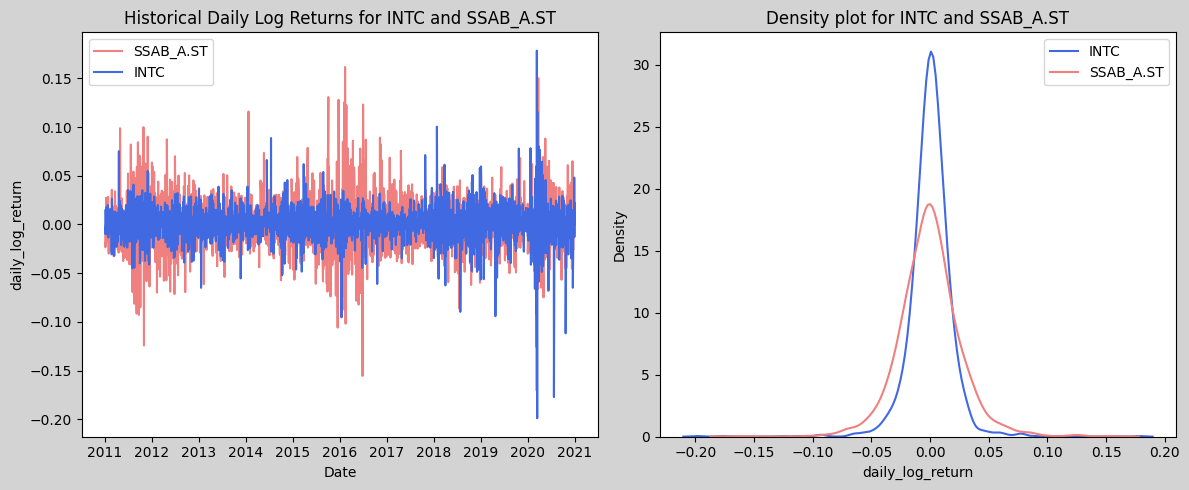

In [33]:
#Optional: historical log returns visualization
fig = plt.figure(figsize=(12,5),facecolor='lightgray',tight_layout=True)

#Plot the density
plt.subplot(1,2,1)
sns.lineplot(data=historical_log_returns_ssab, x=historical_log_returns_ssab.index, y='daily_log_return', color='lightcoral', label='SSAB_A.ST')
sns.lineplot(data=historical_log_returns_intc, x=historical_log_returns_intc.index, y='daily_log_return', color='royalblue', label='INTC')
plt.title('Historical Daily Log Returns for INTC and SSAB_A.ST')

plt.subplot(1,2,2)
sns.kdeplot(historical_log_returns_intc['daily_log_return'], color='royalblue', label='INTC')  
sns.kdeplot(historical_log_returns_ssab['daily_log_return'], color='lightcoral', label='SSAB_A.ST')
plt.title('Density plot for INTC and SSAB_A.ST')
plt.legend()

3. 	Assume that daily log-return follows a normal distribution with some constant mean “μ” and variance to be calcualted as below: <br> $\sigma_t^2 = 0.94\sigma_{t-1}^2 + 0.06R_{t-1}^2$. where $\sigma_t^2$ is the variance of log-return at day “t”. You may take initial estimate of $\sigma_t^2$.
 Estimate of the unknown parameters using historical data. Simulate, for the next 4 and half years, the trajectories of the share prices starting from the first trading day of 2021 using the normal model. For simplicity, you may assume that a trading year consists of 252 trading days.

In [34]:
#Function to compute normal distribution parameters
def compute_norm_parameters(data):
    '''Compute mean, variance and standard deviation of log returns'''
    mean = data['daily_log_return'].mean()
    var = data['daily_log_return'].var(ddof=0)
    std = data['daily_log_return'].std(ddof=0)
    return mean, var, std


In [35]:
#Compute mean, variance and standard deviation using compute_normal_distribution_parameters function
mean_intc, var_intc, std_intc = compute_norm_parameters(historical_log_returns_intc)
mean_ssab, var_ssab, std_ssab = compute_norm_parameters(historical_log_returns_ssab)

pd.DataFrame({
    'Stock': ['Intel', 'SSAB'],
    'Mean': [mean_intc, mean_ssab],
    'Variance': [var_intc, var_ssab],
    'Standard Deviation': [std_intc, std_ssab]
})

,Stock,Mean,Variance,Standard Deviation
0,Intel,0.000467,0.000329,0.018148
1,SSAB,-0.000436,0.000715,0.026747


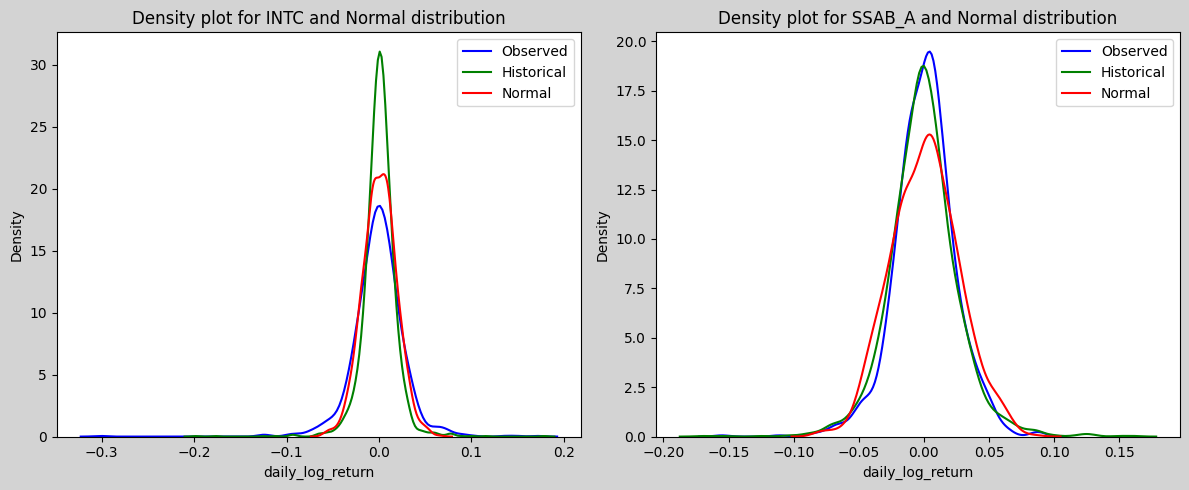

In [36]:
#Optional: Plot the density plots for observed, historical log returns and normal distribution
fig = plt.figure(figsize=(12,5),facecolor='lightgray',tight_layout=True)

#Plot the density
plt.subplot(1,2,1)
sns.kdeplot(observed_log_returns_intc['daily_log_return'], color='blue', label='Observed')  
sns.kdeplot(historical_log_returns_intc['daily_log_return'], color='green', label='Historical')
sns.kdeplot(np.random.normal(mean_intc, std_intc, len(observed_log_returns_intc)), color='red', label='Normal')
plt.title('Density plot for INTC and Normal distribution')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(observed_log_returns_ssab['daily_log_return'], color='blue', label='Observed')  
sns.kdeplot(historical_log_returns_ssab['daily_log_return'], color='green', label='Historical')
sns.kdeplot(np.random.normal(mean_ssab, std_ssab, len(observed_log_returns_ssab)), color='red', label='Normal')
plt.title('Density plot for SSAB_A and Normal distribution')
plt.legend()

In [ ]:
#
def simulate_morgan_closing_price(initial_price, mean, initial_var, number_of_trading_days=252*4.5):
    """
    Simulate closing prices using Morgan's method
    """
    alpha=0.94
    variances = [initial_var] #list of variances for INTC
    prices = [initial_price]  #list of prices for INTC
    initial_log_return = np.random.normal(mean, np.sqrt(initial_var))
    log_returns = [initial_log_return]  #list of log returns for INTC
    for t in range(1, int(number_of_trading_days)):
        var_t = alpha * variances[-1] + (1-alpha) * (log_returns[-1] ** 2) #update variance
        r_t = np.random.normal(mean, np.sqrt(var_t)) #simulate return_t based on updated variance var_t
        price_t = prices[-1]*np.exp(r_t) #compute price_t based on return_t and price_(t-1)

        variances.append(var_t)
        log_returns.append(r_t)
        prices.append(price_t)
        
    return variances, log_returns, prices

In [62]:
#Simulate closing prices for INTC and SSAB
np.random.seed(19121999)
simulated_variances_intc, simulated_log_returns_intc, simulated_closing_prices_intc = simulate_morgan_closing_price(
    initial_price=initial_price_intc,
    mean=mean_intc,
    initial_var=var_intc
)
np.random.seed(19121999)
simulated_variances_ssab, simulated_log_returns_ssab, simulated_closing_prices_ssab = simulate_morgan_closing_price(
    initial_price=initial_price_ssab,
    mean=mean_ssab,
    initial_var=var_ssab
)

In [70]:
# Create new columns in observed dataframes for simulated prices
observed_intc['Simulated Price'] = simulated_closing_prices_intc[:len(observed_intc)]
observed_ssab['Simulated Price'] = simulated_closing_prices_ssab[:len(observed_ssab)]

# Merge the two datasets to create a portfolio view
portfolio = pd.merge(observed_intc, observed_ssab, left_index=True, right_index=True, suffixes=('_INTC', '_SSAB'), how='outer')
portfolio.drop(columns=['Close_sek2usd','Close_inSEK'], inplace=True)

# Fill missing values using forward fill
portfolio['Close_INTC'].fillna(method='ffill', inplace=True)
portfolio['Close_SSAB'].fillna(method='ffill', inplace=True)
portfolio['Simulated Price_INTC'].fillna(method='ffill', inplace=True)
portfolio['Simulated Price_SSAB'].fillna(method='ffill', inplace=True)

# Create new columns in observed dataframes for simulated prices
portfolio['Actual value_INTC'] = (portfolio['Close_INTC'] * intc_shares)
portfolio["Actual value_SSAB"] = (portfolio['Close_SSAB'] * ssab_shares)
portfolio['Simulated value_INTC'] = (portfolio['Simulated Price_INTC'] * intc_shares)
portfolio['Simulated value_SSAB'] = (portfolio['Simulated Price_SSAB'] * ssab_shares)
portfolio['Portfolio Actual Value'] = (portfolio['Close_INTC'] * intc_shares) + (portfolio['Close_SSAB'] * ssab_shares)
portfolio['Portfolio Simulated Value'] = (portfolio['Simulated Price_INTC'] * intc_shares) + (portfolio['Simulated Price_SSAB'] * ssab_shares)
portfolio

,Close_INTC,Simulated Price_INTC,Close_SSAB,Simulated Price_SSAB,Actual value_INTC,Actual value_SSAB,Simulated value_INTC,Simulated value_SSAB,Portfolio Actual Value,Portfolio Simulated Value
Date,,,,,,,,,,
2021-01-04,44.902935,44.902935,2.602707,2.602707,500.000000,500.000000,500.000000,500.000000,1000.000000,1000.000000
2021-01-05,45.752720,43.647539,2.601689,2.492882,509.462464,499.804378,486.021000,478.901797,1009.266843,964.922797
2021-01-06,46.195690,44.636471,2.601689,2.492882,514.394996,499.804378,497.032884,478.901797,1014.199374,975.934681
2021-01-07,47.181080,45.784981,2.735207,2.574314,525.367438,525.454290,509.821691,494.545547,1050.821727,1004.367239
2021-01-08,46.692905,47.088567,2.694265,2.670053,519.931552,517.589062,524.337295,512.937585,1037.520615,1037.274880
...,...,...,...,...,...,...,...,...,...,...
2025-06-23,21.190001,77.333075,5.877351,1.684111,235.953402,1129.084170,861.113814,323.530672,1365.037572,1184.644486
2025-06-24,22.549999,78.211170,5.838422,1.666821,251.097164,1121.605644,870.891516,320.209175,1372.702807,1191.100691
2025-06-25,22.200001,78.738540,5.849694,1.648815,247.199885,1123.770981,876.763849,316.750090,1370.970866,1193.513939


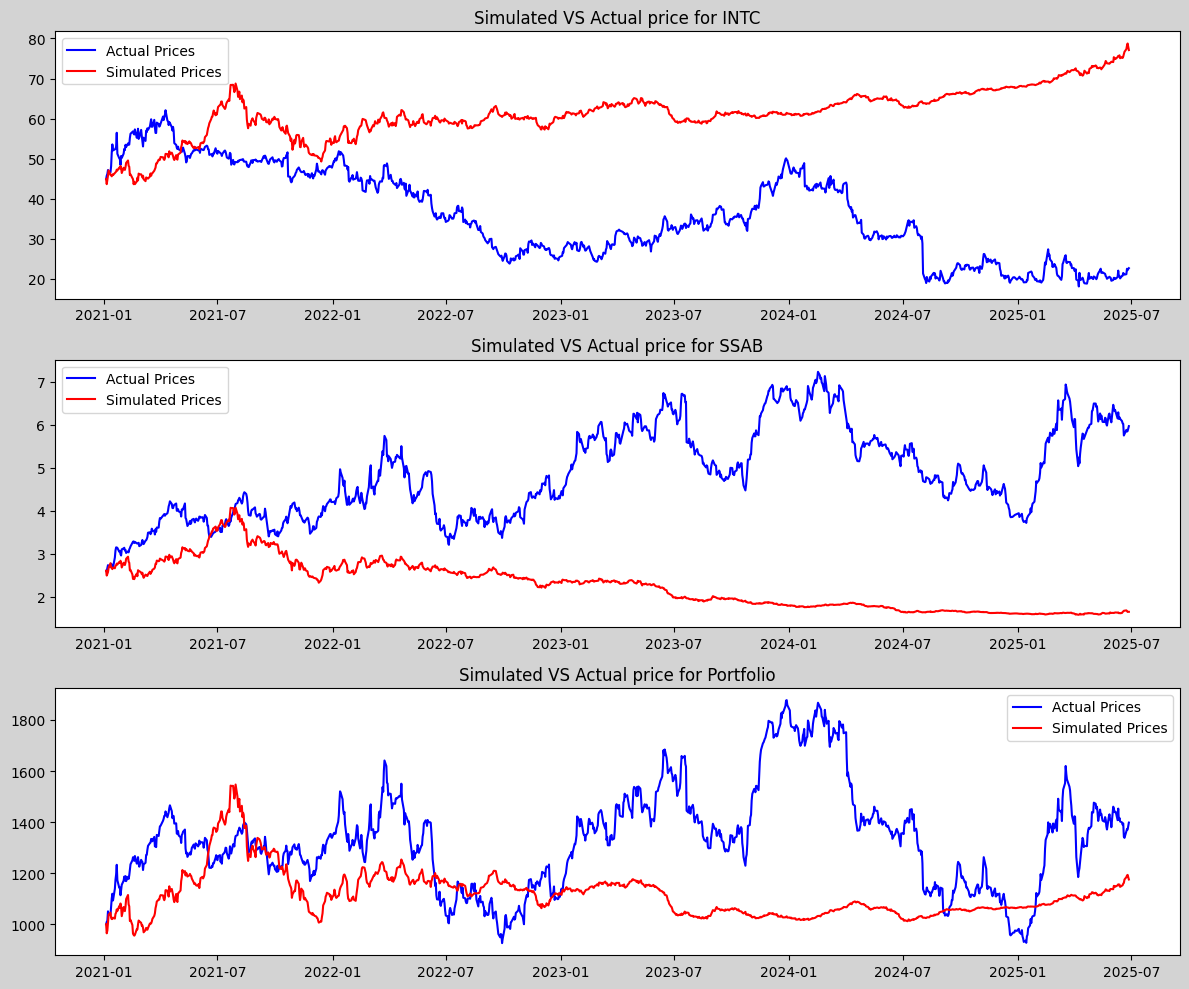

In [71]:
fig = plt.figure(figsize=(12,10),facecolor='lightgray',tight_layout=True)

#Plot 1 price path for intc
plt.subplot(3,1,1)
plt.plot(observed_intc['Close'], color='blue', label='Actual Prices')
plt.plot(observed_intc['Simulated Price'], color='red', label='Simulated Prices')
plt.title('Simulated VS Actual price for INTC')
plt.legend()

#Plot 1 price path for ssab
plt.subplot(3,1,2)
plt.plot(observed_ssab['Close'], color='blue', label='Actual Prices')
plt.plot(observed_ssab['Simulated Price'], color='red', label='Simulated Prices')
plt.title('Simulated VS Actual price for SSAB')
plt.legend()

#Plot 1 path/scenario for portfolio
plt.subplot(3,1,3)
plt.plot(portfolio['Portfolio Actual Value'], color='blue', label='Actual Prices')
plt.plot(portfolio['Portfolio Simulated Value'], color='red', label='Simulated Prices')
plt.title('Simulated VS Actual price for Portfolio')
plt.legend()


4. Based on a large number of simulated trajectories (as in task 3), do you find your investment profitable? How much profit/loss do you expect? Compare your simulation results with the actual result (as per the real stock process on the last trading day of June, 2025). Also give a VaR at confidence level 90% of your investment (for the same time window, as in problem 1).

In [ ]:
from tqdm import tqdm

#Function to simulate ending prices
def simulate_ending_price(initial_price, mean, initial_var, number_of_trading_days=252*4.5, num_of_simulations=10000):
    """
    Simulate ending prices for a given number of simulations
    """
    simulated_ending_prices=[]
    for i in tqdm(range(num_of_simulations)):
        simulated_var, simulated_returns, simulated_closing_prices= simulate_morgan_closing_price(initial_price, mean, initial_var, number_of_trading_days)
        simulated_ending_price=simulated_closing_prices[-1]
        simulated_ending_prices.append(simulated_ending_price)
    return simulated_ending_prices

In [73]:
#10000 random scenarios to simulate ending prices for INTC and SSAB

np.random.seed(19121999)
simulated_ending_prices_intc = simulate_ending_price(
    initial_price=initial_price_intc, 
    mean=mean_intc, 
    initial_var=var_intc)
expected_ending_price_intc = np.mean(simulated_ending_prices_intc)

np.random.seed(19121999)
simulated_ending_prices_ssab=simulate_ending_price(
    initial_price=initial_price_ssab, 
    mean=mean_ssab, 
    initial_var=var_ssab)
expected_ending_price_ssab = np.mean(simulated_ending_prices_ssab)


100%|██████████| 10000/10000 [00:36<00:00, 271.17it/s]


In [93]:
#Calculate the simulated portfolio value based simulation of 2 shares:
simulated_portfolio = pd.DataFrame({
    'INTC ending price': simulated_ending_prices_intc,
    'SSAB ending price': simulated_ending_prices_ssab,
})
simulated_portfolio['INTC ending value'] = simulated_portfolio['INTC ending price'] * intc_shares
simulated_portfolio['SSAB ending value'] = simulated_portfolio['SSAB ending price'] * ssab_shares
simulated_portfolio['Portfolio value'] = simulated_portfolio['INTC ending value'] + simulated_portfolio['SSAB ending value']
simulated_portfolio.describe().round(2)


,INTC ending price,SSAB ending price,INTC ending value,SSAB ending value,Portfolio value
count,10000.00,10000.00,10000.00,1.000000e+04,1.000000e+04
mean,575.72,593.86,6410.75,1.140844e+05,1.204951e+05
std,41175.96,54694.70,458499.65,1.050727e+07,1.096518e+07
min,0.00,0.00,0.00,0.000000e+00,0.000000e+00
25%,59.58,1.12,663.44,2.159600e+02,8.803800e+02
50%,75.76,1.60,843.60,3.078100e+02,1.150830e+03
75%,97.20,2.28,1082.33,4.377700e+02,1.521610e+03
max,4097694.86,5463155.06,45628363.29,1.049514e+09,1.095142e+09


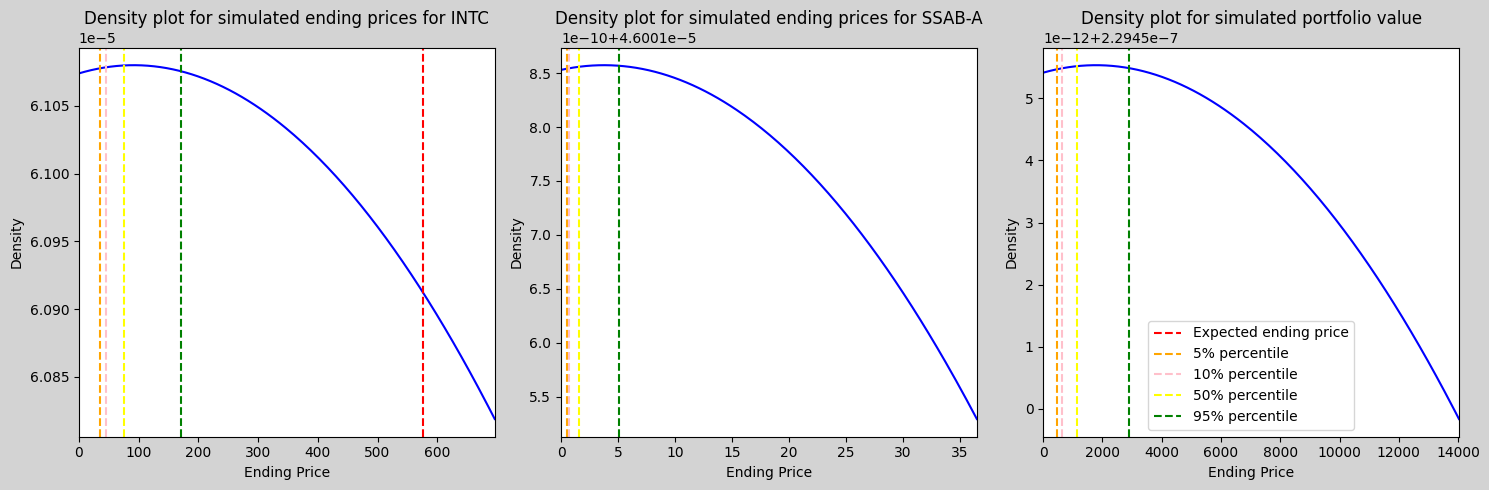

In [94]:
#Plot the density of simulated ending prices for 2 shares
fig = plt.figure(figsize=(15,5),facecolor='lightgray',tight_layout=True)

#INTC
plt.subplot(1,3,1)
intc_upper = np.percentile(simulated_ending_prices_intc, 99.5) # Remove outlier for better
sns.kdeplot(simulated_ending_prices_intc, color='blue', clip=(0, intc_upper))
plt.axvline(expected_ending_price_intc, color='red', linestyle='--', label='Expected ending price')
plt.axvline(np.percentile(simulated_ending_prices_intc, 5), color='orange', linestyle='--', label='5% percentile')
plt.axvline(np.percentile(simulated_ending_prices_intc, 10), color='pink', linestyle='--', label='10% percentile')
plt.axvline(np.percentile(simulated_ending_prices_intc, 50), color='yellow', linestyle='--', label='50% percentile')
plt.axvline(np.percentile(simulated_ending_prices_intc, 95), color='green', linestyle='--', label='95% percentile')
plt.xlim(0, intc_upper)
plt.xlabel('Ending Price')
plt.title('Density plot for simulated ending prices for INTC')

#SSAB
plt.subplot(1,3,2)
ssab_upper = np.percentile(simulated_ending_prices_ssab, 99.5) # Remove outlier for better
sns.kdeplot(simulated_ending_prices_ssab, color='blue', clip=(0, ssab_upper))
plt.axvline(expected_ending_price_ssab, color='red', linestyle='--', label='Expected ending price')
plt.axvline(np.percentile(simulated_ending_prices_ssab, 5), color='orange', linestyle='--', label='5% percentile')
plt.axvline(np.percentile(simulated_ending_prices_ssab, 10), color='pink', linestyle='--', label='10% percentile')
plt.axvline(np.percentile(simulated_ending_prices_ssab, 50), color='yellow', linestyle='--', label='50% percentile')
plt.axvline(np.percentile(simulated_ending_prices_ssab, 95), color='green', linestyle='--', label='95% percentile')
plt.xlim(0, ssab_upper)
plt.xlabel('Ending Price')
plt.title('Density plot for simulated ending prices for SSAB-A')

# Plot the density of portfolio
plt.subplot(1,3,3)
portfolio_upper = np.percentile(simulated_portfolio['Portfolio value'], 99.5) # Remove outlier for better
sns.kdeplot(simulated_portfolio['Portfolio value'], color='blue', clip=(0, portfolio_upper))
plt.axvline(np.mean(simulated_portfolio['Portfolio value']), color='red', linestyle='--', label='Expected ending price')
plt.axvline(np.percentile(simulated_portfolio['Portfolio value'], 5), color='orange', linestyle='--', label='5% percentile')
plt.axvline(np.percentile(simulated_portfolio['Portfolio value'], 10), color='pink', linestyle='--', label='10% percentile')
plt.axvline(np.percentile(simulated_portfolio['Portfolio value'], 50), color='yellow', linestyle='--', label='50% percentile')
plt.axvline(np.percentile(simulated_portfolio['Portfolio value'], 95), color='green', linestyle='--', label='95% percentile')
plt.title('Density plot for simulated portfolio value')
plt.xlim(0, portfolio_upper)
plt.xlabel('Ending Price')
plt.legend()


In [95]:
#Compare expected and actual profit/loss
compare_df=pd.DataFrame({
    'Stock':['INTC', 'SSAB'],
    'Initial Value': [500,500],
    'Shares': [np.round(intc_shares,2),np.round(ssab_shares,2)],
    'Initial Price': [np.round(initial_price_intc,2),np.round(initial_price_ssab,2)],
    'Expected Ending Price': [np.round(expected_ending_price_intc,2), np.round(expected_ending_price_ssab,2)],
    'Median Ending Price': [np.round(np.percentile(simulated_ending_prices_intc,50),2), np.round(np.percentile(simulated_ending_prices_ssab,50),2)],
    '10th Percentile Ending Price': [np.round(np.percentile(simulated_ending_prices_intc,10),2), np.round(np.percentile(simulated_ending_prices_ssab,10),2)],
    'Actual Ending Price': [np.round(observed_intc['Close'].iloc[-1],2), np.round(observed_ssab['Close'].iloc[-1],2)],
    'Expected Ending Value': [np.round(expected_ending_price_intc*intc_shares,2), np.round(expected_ending_price_ssab*ssab_shares,2)],
    'Median Ending Value': [np.round(np.percentile(simulated_ending_prices_intc,50)*intc_shares,2), np.round(np.percentile(simulated_ending_prices_ssab,50)*ssab_shares,2)],
    '10th Percentile Ending Value': [np.round(np.percentile(simulated_ending_prices_intc,10)*intc_shares,2), np.round(np.percentile(simulated_ending_prices_ssab,10)*ssab_shares,2)],
    'Actual Ending Value': [np.round(observed_intc['Close'].iloc[-1]*intc_shares,2), np.round(observed_ssab['Close'].iloc[-1]*ssab_shares,2)]
})


# --- Portfolio row
portfolio_row = pd.DataFrame({
    'Stock': ['Portfolio'],
    'Initial Value': [1000],
    'Shares': [None],
    'Initial Price': [None],
    'Expected Ending Price': [None],
    'Median Ending Price': [None],
    '10th Percentile Ending Price': [None],
    'Actual Ending Price': [None],
    'Expected Ending Value': [np.round(np.mean(simulated_portfolio['Portfolio value']), 2)],
    'Median Ending Value': [np.round(np.percentile(simulated_portfolio['Portfolio value'],50),2)],
    '10th Percentile Ending Value': [np.round(np.percentile(simulated_portfolio['Portfolio value'],10),2)],
    'Actual Ending Value': [np.round(compare_df['Actual Ending Value'].sum(), 2)]
})

compare_df = pd.concat([compare_df, portfolio_row], ignore_index=True)

compare_df['Expected Profit/Loss']=compare_df['Expected Ending Value']-compare_df['Initial Value']
compare_df['Actual Profit/Loss']=compare_df['Actual Ending Value']-compare_df['Initial Value']
compare_df["Value at Risk 90%"]=compare_df['Initial Value'] - compare_df['10th Percentile Ending Value']


In [96]:
# Transposed view
ts_compare_df = (
    compare_df.set_index("Stock")
              .transpose()
              .rename(columns={"Intel": "Intel", "SSAB": "SSAB", "Portfolio": "Portfolio"})
)

ts_compare_df

Stock,INTC,SSAB,Portfolio
Initial Value,500.00,500.00,1000.00
Shares,11.14,192.11,NaN
Initial Price,44.90,2.60,NaN
Expected Ending Price,575.72,593.86,NaN
Median Ending Price,75.76,1.60,NaN
10th Percentile Ending Price,44.82,0.73,NaN
Actual Ending Price,22.69,5.96,NaN
Expected Ending Value,6410.75,114084.39,120495.14
Median Ending Value,843.60,307.81,1150.83
10th Percentile Ending Value,499.11,139.39,639.40
